# TP1: Monocular Visual Odometry


### Importer les bibliothèques

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import files
import io
from PIL import Image
import zipfile



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
K = np.array([[718.8, 0, 607.1],
              [0, 718.8, 185.2],
              [0, 0, 1]])


### Upload des images pour les paires (Section 4-5)

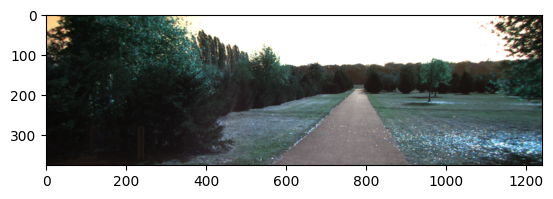

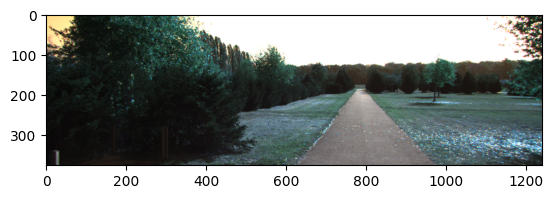

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

I1 = cv2.imread('/content/drive/MyDrive/SLAM/TP1/TP1-20260114/Pairs/000392_d.png')
I2 = cv2.imread('/content/drive/MyDrive/SLAM/TP1/TP1-20260114/Pairs/000392_g.png')

plt.imshow(I1)
plt.show()
plt.imshow(I2)
plt.show()


### Upload des images pour la séquence (Section 6)


In [ ]:
sequence_path = Path("/content/drive/MyDrive/SLAM/TP1/TP1-20260114/Sequence/")

# Lister les images
image_files = sorted(list(sequence_path.glob('*.png')) + list(sequence_path.glob('*.jpg')))

print(f"{len(image_files)} images extraites")
for i, img_file in enumerate(image_files[:5]):
    print(f"  {i+1}. {img_file.name}")
if len(image_files) > 5:
    print(f"  ... et {len(image_files)-5} autres")

5 images extraites
  1. 000358.png
  2. 000359.png
  3. 000360.png
  4. 000361.png
  5. 000362.png


In [ ]:
class VisualOdometry:
    def __init__(self, K):
        """
        Initialiser l'odométrie visuelle avec la matrice de calibration

        Args:
            K: Matrice de calibration intrinsèque (3x3)
        """
        self.K = K
        self.trajectory = []
        self.current_pose = np.eye(4)  # Pose initiale = identité

    def select_points_manual(self, img1, img2):
        """
        Sélection manuelle de points correspondants
        Adapté pour Google Colab (sans interface interactive)
        """
        print("Pour Google Colab, nous utiliserons la détection automatique de features.")
        print("Si vous voulez sélectionner manuellement, utilisez un notebook local.")

        # Détection automatique
        orb = cv2.ORB_create(nfeatures=1000)

        # Convertir en niveaux de gris
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) if len(img1.shape) == 3 else img1
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) if len(img2.shape) == 3 else img2

        # Détecter et calculer
        kp1, des1 = orb.detectAndCompute(gray1, None)
        kp2, des2 = orb.detectAndCompute(gray2, None)

        # Matcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)

        # Extraire les points
        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches[:100]]).reshape(-1, 2)
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches[:100]]).reshape(-1, 2)

        # Visualiser les matches
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None,
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        plt.figure(figsize=(20, 10))
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        plt.title(f'Top 50 matches (total: {len(matches)} matches trouvés)')
        plt.axis('off')
        plt.show()

        return pts1, pts2

    def compute_fundamental_matrix(self, pts1, pts2):
        """
        Calculer la matrice fondamentale F
        """
        F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1.0, 0.99)

        print("MATRICE FONDAMENTALE F")
        print(F)
        print(f"\nInliers: {mask.sum()}/{len(pts1)} ({100*mask.sum()/len(pts1):.1f}%)")

        return F, mask

    def compute_essential_matrix(self, F):
        """
        Calculer la matrice essentielle E = K^T * F * K
        """
        E = self.K.T @ F @ self.K

        print("MATRICE ESSENTIELLE E")
        print(E)

        # Vérifier les propriétés de E (deux valeurs singulières égales)
        U, S, Vt = np.linalg.svd(E)
        print(f"\nValeurs singulières: {S}")
        print(f"Note: E doit avoir deux valeurs singulières égales et une nulle")

        return E

    def recover_pose(self, E, pts1, pts2):
        """
        Récupérer R et t depuis E
        """
        _, R, t, mask = cv2.recoverPose(E, pts1, pts2, self.K)

        print("POSE RELATIVE (R, t)")

        print("\nMatrice de Rotation R:")
        print(R)

        # Vérifier que R est orthogonale
        print(f"\nVérification orthogonalité: det(R) = {np.linalg.det(R):.6f} (doit être ~1)")
        print(f"R @ R^T = I ? Erreur max: {np.max(np.abs(R @ R.T - np.eye(3))):.2e}")

        # Angle de rotation
        angle = np.arccos((np.trace(R) - 1) / 2) * 180 / np.pi
        print(f"\nAngle de rotation: {angle:.2f}°")

        print("\nVecteur de Translation t (direction):")
        print(t.flatten())
        print(f"Norme: {np.linalg.norm(t):.6f} (normalisé à 1)")

        return R, t

    def create_transformation_matrix(self, R, t):
        """
        Créer la matrice de transformation homogène 4x4
        """
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t.flatten()
        return T

    def update_trajectory(self, R, t):
        """
        Mettre à jour la trajectoire
        """
        T_relative = self.create_transformation_matrix(R, t)
        self.current_pose = self.current_pose @ T_relative
        position = self.current_pose[:3, 3]
        self.trajectory.append(position.copy())
        return position

    def plot_trajectory(self):
        """
        Visualiser la trajectoire reconstruite
        """
        if len(self.trajectory) == 0:
            print("Pas de trajectoire à afficher")
            return

        trajectory = np.array(self.trajectory)

        fig = plt.figure(figsize=(16, 12))

        # Vue 3D
        ax1 = fig.add_subplot(221, projection='3d')
        ax1.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2],
                'b-o', linewidth=2, markersize=5)
        ax1.scatter(trajectory[0, 0], trajectory[0, 1], trajectory[0, 2],
                   c='g', s=100, marker='o', label='Départ')
        ax1.scatter(trajectory[-1, 0], trajectory[-1, 1], trajectory[-1, 2],
                   c='r', s=100, marker='*', label='Arrivée')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.set_title('Trajectoire 3D')
        ax1.legend()
        ax1.grid(True)

        # Vue de dessus (X-Z)
        ax2 = fig.add_subplot(222)
        ax2.plot(trajectory[:, 0], trajectory[:, 2], 'b-o', linewidth=2, markersize=5)
        ax2.scatter(trajectory[0, 0], trajectory[0, 2], c='g', s=100, marker='o')
        ax2.scatter(trajectory[-1, 0], trajectory[-1, 2], c='r', s=100, marker='*')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Z')
        ax2.set_title('Vue de dessus (X-Z)')
        ax2.grid(True)
        ax2.axis('equal')

        # Vue de côté (X-Y)
        ax3 = fig.add_subplot(223)
        ax3.plot(trajectory[:, 0], trajectory[:, 1], 'b-o', linewidth=2, markersize=5)
        ax3.scatter(trajectory[0, 0], trajectory[0, 1], c='g', s=100, marker='o')
        ax3.scatter(trajectory[-1, 0], trajectory[-1, 1], c='r', s=100, marker='*')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_title('Vue de côté (X-Y)')
        ax3.grid(True)
        ax3.axis('equal')

        # Vue frontale (Z-Y)
        ax4 = fig.add_subplot(224)
        ax4.plot(trajectory[:, 2], trajectory[:, 1], 'b-o', linewidth=2, markersize=5)
        ax4.scatter(trajectory[0, 2], trajectory[0, 1], c='g', s=100, marker='o')
        ax4.scatter(trajectory[-1, 2], trajectory[-1, 1], c='r', s=100, marker='*')
        ax4.set_xlabel('Z')
        ax4.set_ylabel('Y')
        ax4.set_title('Vue frontale (Z-Y)')
        ax4.grid(True)
        ax4.axis('equal')

        plt.tight_layout()
        plt.show()

        print(f"\n Trajectoire reconstruite avec {len(self.trajectory)} poses")

print("Classe VisualOdometry définie")

Classe VisualOdometry définie!


## Section 4-5: Sélection de Points et Estimation de Pose

### Traitement d'une paire d'images


Étape 1: Détection et appariement de features...
Pour Google Colab, nous utiliserons la détection automatique de features.
Si vous voulez sélectionner manuellement, utilisez un notebook local.


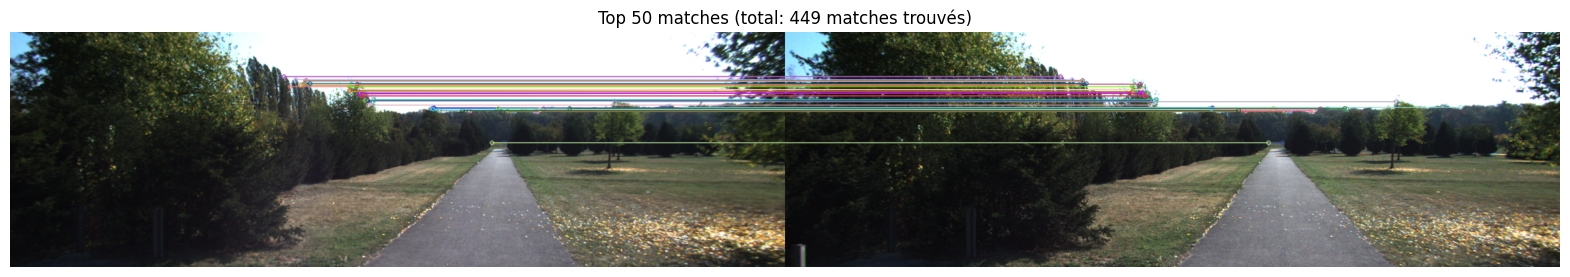


 100 correspondances détectées

Premiers points dans image 1:
[[474.        77.      ]
 [472.78085   78.796814]
 [679.3115   121.92771 ]
 [559.8721    91.23841 ]
 [782.328    122.42538 ]]

Points correspondants dans image 2:
[[476.        77.      ]
 [474.85446   78.796814]
 [684.28815  121.92771 ]
 [572.31366   91.23841 ]
 [782.328    122.42538 ]]


In [ ]:
# Initialiser
vo = VisualOdometry(K)

# Sélectionner les points (automatique pour Colab)
print("\nÉtape 1: Détection et appariement de features...")
pts1, pts2 = vo.select_points_manual(I1, I2)

print(f"\n {len(pts1)} correspondances détectées")
print(f"\nPremiers points dans image 1:\n{pts1[:5]}")
print(f"\nPoints correspondants dans image 2:\n{pts2[:5]}")

In [ ]:
# Calculer F
print("\nÉtape 2: Calcul de la matrice fondamentale F...")
F, mask = vo.compute_fundamental_matrix(pts1, pts2)


Étape 2: Calcul de la matrice fondamentale F...
MATRICE FONDAMENTALE F
[[ 1.45304650e-22  1.14569811e-17 -1.39254538e-15]
 [-1.14272227e-17 -1.41352364e-19 -7.83564153e-03]
 [ 1.38897487e-15  7.83564153e-03  3.33066907e-15]]

Inliers: 90/100 (90.0%)


In [ ]:
# Calculer E
print("\nÉtape 3: Calcul de la matrice essentielle E...")
E = vo.compute_essential_matrix(F)


Étape 3: Calcul de la matrice essentielle E...
MATRICE ESSENTIELLE E
[[ 7.50750535e-17  5.91951782e-12  5.24275270e-13]
 [-5.90414245e-12 -7.30330121e-14 -5.63225913e+00]
 [-5.22753450e-13  5.63225913e+00 -1.99840144e-15]]

Valeurs singulières: [5.63225913e+00 5.63225913e+00 7.50750535e-17]
Note: E doit avoir deux valeurs singulières égales et une nulle


In [ ]:
# Récupérer R et t
print("\nÉtape 4: Récupération de la pose (R, t)...")
# Filtrer les inliers
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

R, t = vo.recover_pose(E, pts1_inliers, pts2_inliers)


Étape 4: Récupération de la pose (R, t)...
POSE RELATIVE (R, t)

Matrice de Rotation R:
[[ 1.00000000e+00 -2.70196967e-16  2.72987634e-15]
 [ 2.70196967e-16  1.00000000e+00 -6.66133815e-15]
 [-2.72987634e-15  6.77236045e-15  1.00000000e+00]]

Vérification orthogonalité: det(R) = 1.000000 (doit être ~1)
R @ R^T = I ? Erreur max: 2.22e-16

Angle de rotation: 0.00°

Vecteur de Translation t (direction):
[ 1.00000000e+00  9.30843659e-14 -1.05100239e-12]
Norme: 1.000000 (normalisé à 1)


### Visualisation de la géométrie épipolaire

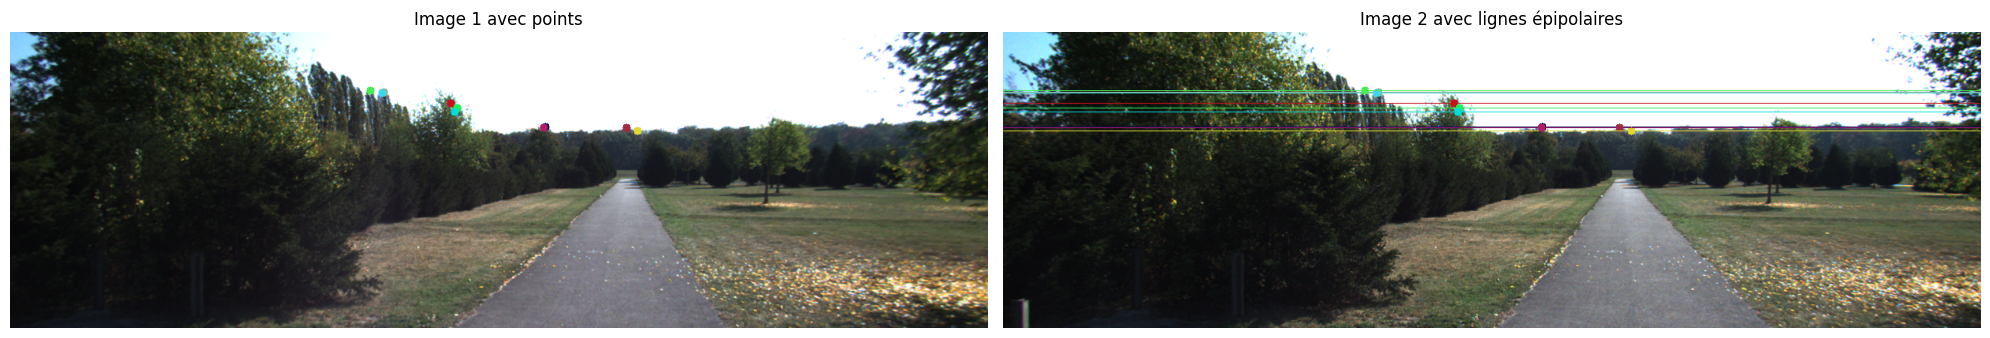


 Les points de l'image 1 doivent se trouver sur les lignes épipolaires de l'image 2


In [ ]:
# Visualiser les lignes épipolaires
def draw_epilines(img1, img2, lines, pts1, pts2):
    """
    Dessiner les lignes épipolaires
    """
    r, c = img1.shape[:2]
    img1_color = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) if len(img1.shape) == 3 else cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) if len(img2.shape) == 3 else cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

    # Prendre seulement 10 points pour la clarté
    for line, pt1, pt2 in zip(lines[:10], pts1[:10], pts2[:10]):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -line[2]/line[1]])
        x1, y1 = map(int, [c, -(line[2]+line[0]*c)/line[1]])
        img2_color = cv2.line(img2_color, (x0, y0), (x1, y1), color, 1)
        img2_color = cv2.circle(img2_color, tuple(map(int, pt2)), 5, color, -1)
        img1_color = cv2.circle(img1_color, tuple(map(int, pt1)), 5, color, -1)

    return img1_color, img2_color

# Calculer les lignes épipolaires
lines2 = cv2.computeCorrespondEpilines(pts1_inliers.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)

img1_epi, img2_epi = draw_epilines(I1, I2, lines2, pts1_inliers, pts2_inliers)

# Afficher
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].imshow(img1_epi)
axes[0].set_title('Image 1 avec points')
axes[0].axis('off')
axes[1].imshow(img2_epi)
axes[1].set_title('Image 2 avec lignes épipolaires')
axes[1].axis('off')
plt.tight_layout()
plt.show()

print("\n Les points de l'image 1 doivent se trouver sur les lignes épipolaires de l'image 2")

## Section 6: Reconstruction de Trajectoire

### Traitement de la séquence d'images

In [ ]:
# Initialiser nouvelle instance
vo_seq = VisualOdometry(K)

# Position initiale à l'origine
vo_seq.trajectory.append(np.zeros(3))

print(f"\nNombre d'images: {len(image_files)}")
print(f"Traitement de {len(image_files)-1} paires...\n")

# Traiter chaque paire consécutive
for i in range(len(image_files) - 1):
    print(f"\nPaire {i+1}/{len(image_files)-1}: {image_files[i].name} -> {image_files[i+1].name}")
    print("-" * 60)

    # Charger les images
    img1_seq = cv2.imread(str(image_files[i]))
    img2_seq = cv2.imread(str(image_files[i+1]))

    # Détecter features avec ORB
    orb = cv2.ORB_create(nfeatures=2000)

    gray1 = cv2.cvtColor(img1_seq, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_seq, cv2.COLOR_BGR2GRAY)

    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # Matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Extraire points
    pts1_seq = np.float32([kp1[m.queryIdx].pt for m in matches[:100]]).reshape(-1, 2)
    pts2_seq = np.float32([kp2[m.trainIdx].pt for m in matches[:100]]).reshape(-1, 2)

    print(f"Matches trouvés: {len(matches)}")

    # Calculer F
    F_seq, mask_seq = vo_seq.compute_fundamental_matrix(pts1_seq, pts2_seq)

    # Filtrer inliers
    pts1_seq = pts1_seq[mask_seq.ravel() == 1]
    pts2_seq = pts2_seq[mask_seq.ravel() == 1]

    # Calculer E
    E_seq = vo_seq.compute_essential_matrix(F_seq)

    # Récupérer pose
    R_seq, t_seq = vo_seq.recover_pose(E_seq, pts1_seq, pts2_seq)

    # Mettre à jour trajectoire
    position = vo_seq.update_trajectory(R_seq, t_seq)
    print(f"\nPosition actuelle: [{position[0]:.3f}, {position[1]:.3f}, {position[2]:.3f}]")

print("\n" + "="*60)
print("Traitement terminé!")
print("="*60)


Nombre d'images: 5
Traitement de 4 paires...


Paire 1/4: 000358.png -> 000359.png
------------------------------------------------------------
Matches trouvés: 1013
MATRICE FONDAMENTALE F
[[ 8.33428823e-07 -7.90224717e-04  1.27803808e-01]
 [ 7.93826488e-04  9.98617987e-06 -4.90280121e-01]
 [-1.29466022e-01  4.84639481e-01  1.00000000e+00]]

Inliers: 88/100 (88.0%)
MATRICE ESSENTIELLE E
[[ 4.30610537e-01 -4.08288123e+02 -1.29670331e+01]
 [ 4.10149062e+02  5.15959390e+00 -4.67120770e+00]
 [ 1.29790973e+01  4.84722491e+00  8.82189333e-04]]

Valeurs singulières: [4.12002524e+02 4.06920249e+02 1.11801405e-14]
Note: E doit avoir deux valeurs singulières égales et une nulle
POSE RELATIVE (R, t)

Matrice de Rotation R:
[[ 9.99976654e-01  6.83245769e-03 -9.91430766e-05]
 [-6.83244079e-03  9.99976644e-01  1.69804012e-04]
 [ 1.00300940e-04 -1.69122659e-04  9.99999981e-01]]

Vérification orthogonalité: det(R) = 1.000000 (doit être ~1)
R @ R^T = I ? Erreur max: 4.44e-16

Angle de rotation: 0.39°


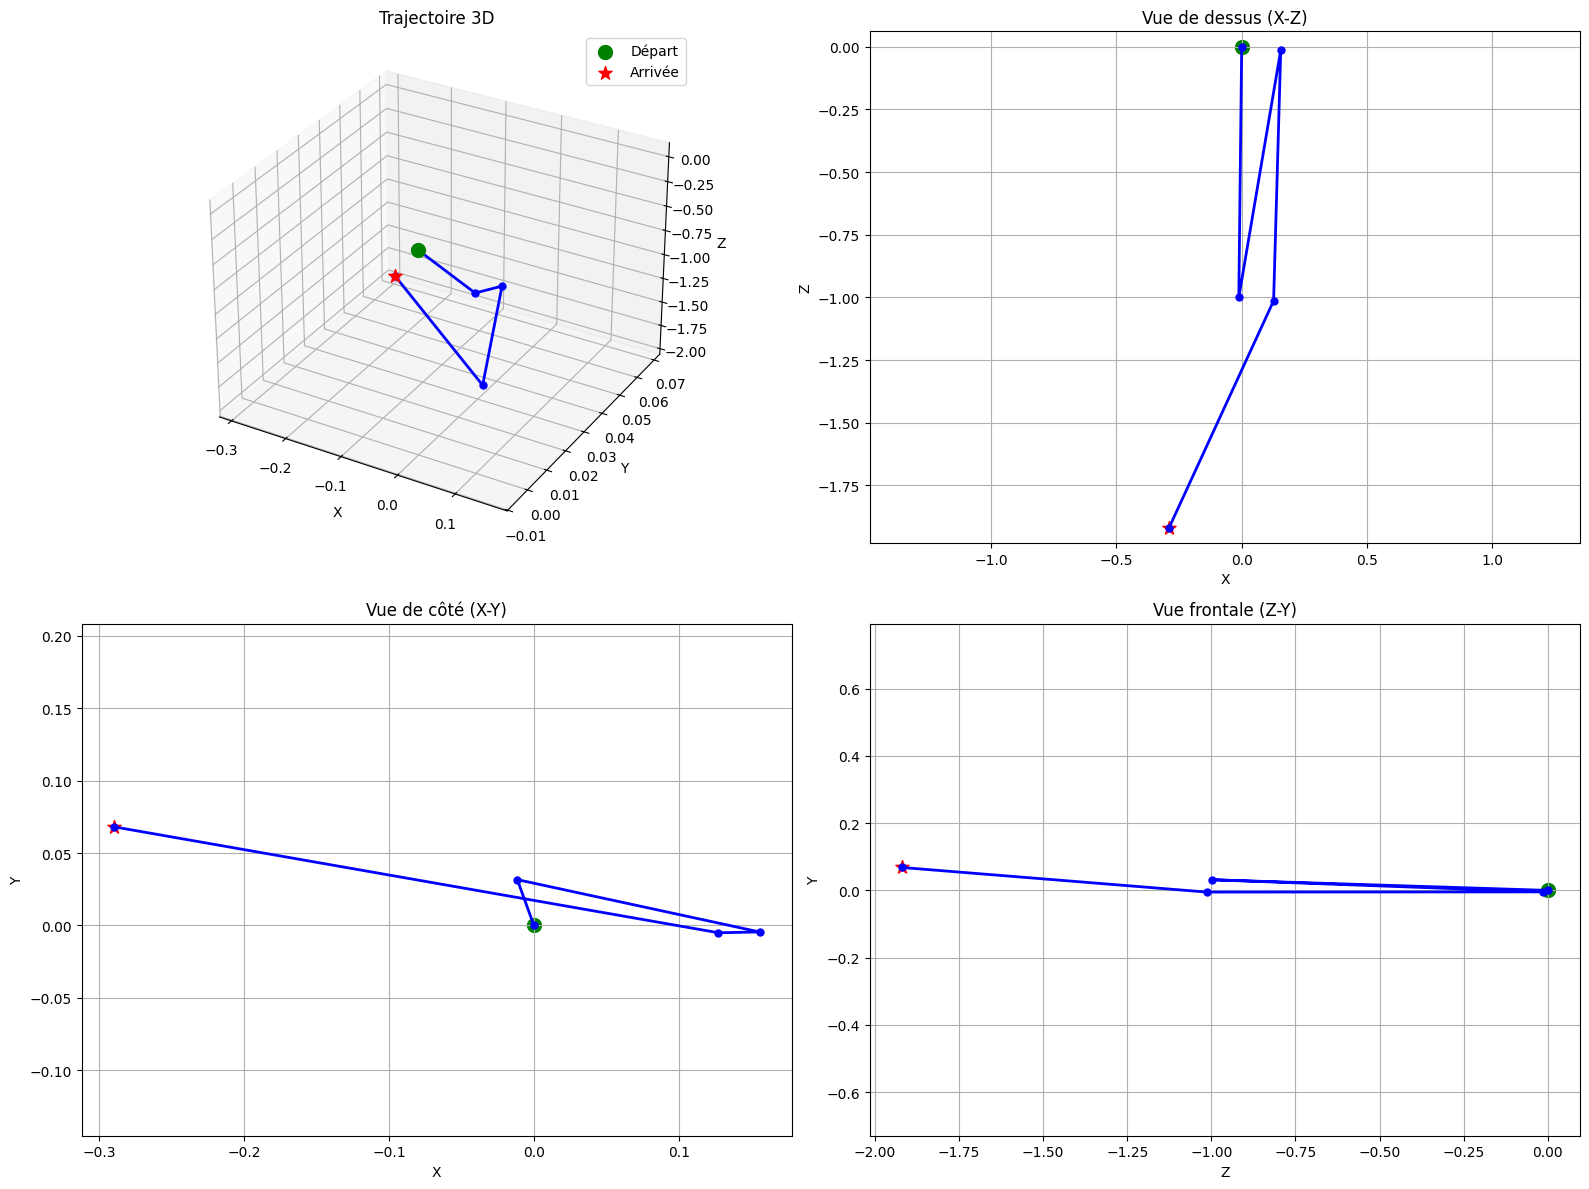


 Trajectoire reconstruite avec 5 poses


In [ ]:
# Visualiser la trajectoire
vo_seq.plot_trajectory()


## Section 7: Questions Théoriques

### 7.1 Parallax
Quand les points sont éloignés de la caméra, leur déplacement entre deux images est très faible. La parallaxe (le mouvement apparent dû au déplacement de la caméra) devient donc petite. Comme la translation est estimée à partir de ce mouvement, une faible parallaxe rend l’estimation sensible au bruit et donc peu précise.

### 7.2 Matrice K
La matrice intrinsèque K est nécessaire pour convertir la matrice fondamentale (F) en matrice essentielle (E), car F est exprimée en coordonnées pixels alors que E doit être exprimée en coordonnées caméra normalisées.
La matrice K contient les paramètres internes de la caméra : longueur focale, centre principal et facteurs d’échelle (paramètres intrinsèques).

### 7.3 Ambiguïté d’échelle
Le vecteur de translation t est estimé seulement à un facteur d’échelle près, car avec une seule caméra on ne peut pas connaître la vraie distance.
On peut lever cette ambiguïté en utilisant une information supplémentaire, par exemple :

*   une distance connue dans la scène,
*   un capteur externe (GPS, IMU),
* une caméra stéréo
ou la connaissance de la vitesse du véhicule.

### 7.4 Limitations de la VO monoculaire en conduite réelle
Les principales limites sont :

* ambiguïté d’échelle (distance réelle inconnue),

* sensibilité aux changements de lumière,

* erreurs si peu de texture (routes uniformes),

* difficultés avec objets en mouvement (voitures, piétons),

* accumulation d’erreurs au cours du temps (drift),

* faible précision quand la parallaxe est faible (mouvement tout droit).
